In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from qat.core.console import display

# 1. QLM

In [4]:
from qat.lang.AQASM import Program

### 1.1 Haddamard n tensorial

Lo primero es crear una superposición de estados utilizando una puerta **Haddamard** en cada uno de los qbits de entrada. La vamos a implementar como una función que crea una rutina **QLM**. Esta función recibirá el número de qbits

In [5]:
def TensorialHaddamard(n):
    """
    Rutina que implementa una Puerta Hadamard n tensorial
    """
    from qat.lang.AQASM import QRoutine, H
    tensorialHadamard = QRoutine()
    for i in range(n):
        tensorialHadamard.apply(H,i)
    return tensorialHadamard

In [ ]:
#Inicializamos el program
NumberOfQbits = 2
#Definimos el circuito
Circuit = Program()
#Reservamos los qbits que queremos
qbits = Circuit.qalloc(NumberOfQbits)
#Aplicamos el Operado Hadamard n tensorial
Circuit.apply(TensorialHaddamard(NumberOfQbits),qbits)
Groover = Circuit.to_circ()
%qatdisplay Groover

In [ ]:
Job4Groover = Groover.to_job()

Una puerta Haddamard n-tensorial sobre n estados $|0\rangle$ genera una superposición de los vectores base en n dimensiones:

$$H^{\otimes n}|0\rangle_{n} = \frac{1}{2^{n/2}}\sum_{x}|x\rangle$$

De tal modo que todos los vectores de la base son equiprobables

In [ ]:
from qat.qpus import LinAlg
linalgqpu = LinAlg()
result = linalgqpu.submit(Job4Groover)
for sample in result:
    print("State %s amplitude %s" % (sample.state, sample.amplitude))

### 1.2 Oráculo

En general para un oráculo cualquiera siempre se verifica que:
 
 $$O_{f(x)}|x \rangle \otimes |q_{t}\rangle = |x\rangle \otimes |q_{t} \oplus f(x)\rangle$$ 
 
 Para el caso de un oráculo de Groover es demostrable que para un estado $|x\rangle$:
 
  $$O_{f(x)}|x \rangle \otimes |-\rangle = (-1)^{f(x)}|x\rangle \otimes |-\rangle$$ 
 
 Con $f(x)$ verificando que:
 
 $$f(x) = \Big\{
 \begin{array}{ll}
     1
     & x = w \\
     0 & x \neq w \\
 \end{array}
$$

Cabe destacar que el oráculo tambien se puede poner como:

$$U_f = I -2|\omega \rangle \langle \omega|$$

In [6]:
#Se implementa la Lotería que devuelve el número en decimal y binario

def ToBinnary(Number, NumberOfBits):
    """
    Recibe un numero en decimal y lo convierte a bits
    """
    if Number > 2**NumberOfBits-1:
        print('No puedo')
        return None
    stringFormat = '0{}b'.format(NumberOfBits)
    bNumber = format(Number, stringFormat)
    return bNumber


def Loteria(n):
    #Max number of elememnts I can generate
    N_max = 2**n
    print('N_max: {}'.format(N_max))
    #Generate winner number
    Winner = np.random.randint(N_max)
    print('Winner: {}'.format(Winner))
    return Winner#, ToBinnary(Winner, n)

In [7]:
NumberOfBits = 4

Winner = Loteria(NumberOfBits)

N_max: 16
Winner: 5


Voy a implementar el oráculo como una matriz identidad donde el número que se marque será un menos 1 en vez de un 1. Además lo voy a convertir en una puerta cuántica utilizando la clase **AbstractGate**

In [8]:
#Creo Oraculo 
def Oracle_Generator(n, winner):
    Identity = np.identity(2**n)
    Identity[winner, winner] =-1
    return Identity

from qat.lang.AQASM import AbstractGate

#Debemos darle la Arity sino no funciona 
#La arity debe ser el numero de wires que come la puerta lógica
#En nuestro caso des el primer argumento

Oracle = AbstractGate(
    "OracleGroover", 
    [int, int], 
    matrix_generator=Oracle_Generator,
    arity = lambda x,y: x
)

Esto funciona?? Básicamente lo que quiero es que si entra el vector $2^{n}$ que represente el número ganador el producto de la matriz que genera el oráculo por dicho vector me de menos 1 y 1 en cualquier otro caso

In [9]:
#Martriz Oráculo
OracleMatrix = Oracle_Generator(NumberOfBits, Winner)

In [10]:
OracleMatrix

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0

In [11]:
#Esta celda comprueba que lo implemnenté bien!!!
numeroVector = 1
for i in range(2**NumberOfBits):
    BasisVector = np.eye(1, 2**NumberOfBits, i)
    
    Producto = np.dot(OracleMatrix,BasisVector.T)
    
    if np.sum(Producto) == -1:
        print(i, BasisVector, np.sum(Producto))
        print('Winner: {}'.format(Winner))
        

5 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] -1.0
Winner: 5


Montamos un circuito con el oráculo

N_max: 64
Winner: 55
110111


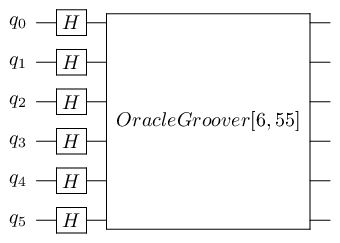

State |110111> amplitude (-0.12499999999999994+0j)
Numero con Amplitud Negativa: 55


In [12]:
#Inicializamos el program
NumberOfQbits = 6
#Montamos la Loteria
Winner = Loteria(NumberOfQbits)
print(ToBinnary(Winner, NumberOfQbits))
#Definimos el circuito
Circuit = Program()
#Reservamos los qbits que queremos
qbits = Circuit.qalloc(NumberOfQbits)
#Aplicamos el Operado Hadamard n tensorial
Circuit.apply(TensorialHaddamard(NumberOfQbits),qbits)
Circuit.apply(Oracle(NumberOfQbits, Winner),qbits)

Groover = Circuit.to_circ()
%qatdisplay Groover

#Fijate que el elejido tiene la amplitud cambiada de signo!!
from qat.qpus import LinAlg
linalgqpu = LinAlg()
Job4Groover = Groover.to_job()
result = linalgqpu.submit(Job4Groover)
#Me saca Amplitudes Negativas
for sample in result:
    if sample.amplitude.real < 0:
        print("State %s amplitude %s" % (sample.state, sample.amplitude))
        Ganador=str(sample.state).replace('|','').replace('>', '')
        print('Numero con Amplitud Negativa: {}'.format(int(Ganador,2)))

### 1.3 Operador Difusión
        

Me toca ahora montar el Operador difusión. Es te operador tiene la forma:

$$D_f = H^{\otimes n}U_{f0}H^{\otimes n}$$ 

Donde:

$$U_{f0} = 2|0\rangle \langle 0| -I$$

Si nos acordamos el oráculo se ponía como:

$$U_f = I -2|\omega \rangle \langle \omega|$$

Para montar $U_{f0}$ puedo utilizar todo lo que tengo del oráculo!!!

In [27]:
def D0_Generator(n):
    Identity = -np.identity(2**n)
    Identity[0, 0] =1
    return Identity

D0 = AbstractGate(
    "Uf0", 
    [int], 
    matrix_generator=D0_Generator,
    arity = lambda x: x
)


def Difusor(n):
    """
    Rutina que implementa el Difusor en n dimensiones
    """        
    from qat.lang.AQASM import QRoutine
    Difusor = QRoutine()
    wires = Difusor.new_wires(n)
    #Aplicamos n Hadamard
    Difusor.apply(TensorialHaddamard(n),wires)
    Difusor.apply(D0(n),wires)
    Difusor.apply(TensorialHaddamard(n),wires)
    return Difusor


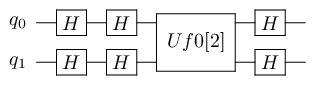

In [31]:
#Testeo Difusor
#Inicializamos el program
NumberOfQbits = 2
#Definimos el circuito
Circuit = Program()
#Reservamos los qbits que queremos
qbits = Circuit.qalloc(NumberOfQbits)
#Generamos mezcla equiprobable de estados
Circuit.apply(TensorialHaddamard(NumberOfQbits),qbits)
#Aplicamos el Operado Hadamard n tensorial
Circuit.apply(Difusor(NumberOfQbits),qbits)
Groover = Circuit.to_circ()
%qatdisplay Groover

In [34]:
#Monto el algoritmo Grover un oráculo seguido de un Difusor
def Grover(n, Winner):
    from qat.lang.AQASM import QRoutine
    Grover = QRoutine()
    wires = Grover.new_wires(n)
    Grover.apply(Oracle(n, Winner),qbits)
    Grover.apply(Difusor(n),qbits)
    return Grover

N_max: 64
Winner: 61
111101


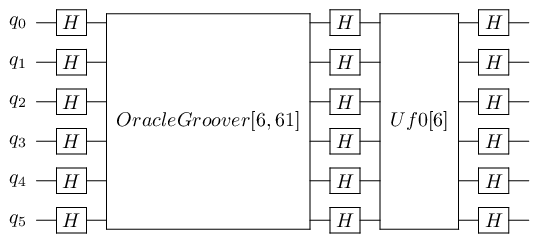

Estado con la mayor Probabilidad: 111101 -> 61


In [73]:
#Inicializamos el program
NumberOfQbits = 6
#Montamos la Loteria
Winner = Loteria(NumberOfQbits)
print(ToBinnary(Winner, NumberOfQbits))
#Definimos el circuito
Circuit = Program()
#Reservamos los qbits que queremos
qbits = Circuit.qalloc(NumberOfQbits)
#Aplicamos el Operado Hadamard n tensorial
Circuit.apply(TensorialHaddamard(NumberOfQbits),qbits)
Circuit.apply(Grover(NumberOfQbits, Winner),qbits)

Groover = Circuit.to_circ()
%qatdisplay Groover

#Fijate que el elejido tiene la amplitud cambiada de signo!!
from qat.qpus import LinAlg
linalgqpu = LinAlg()
Job4Groover = Groover.to_job()
result = linalgqpu.submit(Job4Groover)
#Me saca Amplitudes Negativas
States = []
Probabilities =[]

#Para ver como funciona calculamos todos los estados posibles
#Y sus probabilidades asociadas

for sample in result:
    States.append(sample.state)
    #Probabilidad del estado
    Probabilities.append(np.absolute(sample.amplitude)**2)

#Buscamos el Estado con la mayor probabilidad
idMax = Probabilities.index(max(Probabilities))
States[idMax]
Ganador=str(States[idMax]).replace('|','').replace('>', '')
print('Estado con la mayor Probabilidad: {} -> {}'.format(Ganador, int(Ganador,2)))    

Así pues una aplicación del algoritmo de Grover hace que el estado ganador adquiera una probabilidad mayor que la de los demás estados.

N_max: 16
Winner: 9
1001


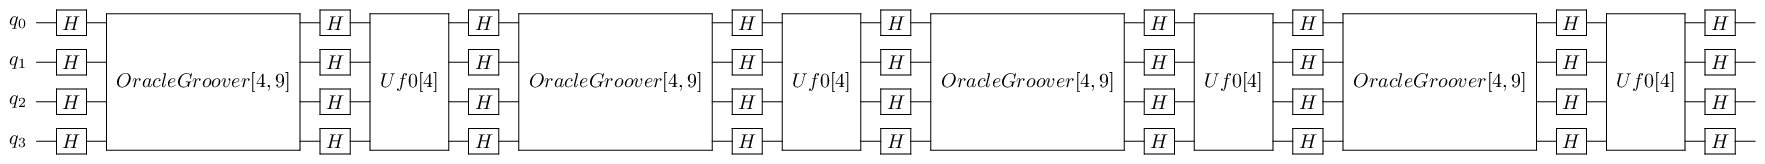

Estado con la mayor Probabilidad: 1001 -> 9


In [100]:
#numero de veces que aplicamos Groover
r=4
#Inicializamos el program
NumberOfQbits = 4
#Montamos la Loteria
Winner = Loteria(NumberOfQbits)
print(ToBinnary(Winner, NumberOfQbits))

#Definimos el circuito
Circuit = Program()
#Reservamos los qbits que queremos
qbits = Circuit.qalloc(NumberOfQbits)
#Aplicamos el Operado Hadamard n tensorial
Circuit.apply(TensorialHaddamard(NumberOfQbits),qbits)

for i in range(r):
    Circuit.apply(Grover(NumberOfQbits, Winner),qbits)

Groover = Circuit.to_circ()
%qatdisplay Groover

#Fijate que el elejido tiene la amplitud cambiada de signo!!
from qat.qpus import LinAlg
linalgqpu = LinAlg()
Job4Groover = Groover.to_job()
result = linalgqpu.submit(Job4Groover)
#Me saca Amplitudes Negativas
States = []
Probabilities =[]
#Para ver como funciona calculamos todos los estados posibles
#Y sus probabilidades asociadas

for sample in result:
    States.append(str(sample.state))
    #Probabilidad del estado
    Probabilities.append(np.absolute(sample.amplitude)**2)

#Buscamos el Estado con la mayor probabilidad
idMax = Probabilities.index(max(Probabilities))
States[idMax]
Ganador=str(States[idMax]).replace('|','').replace('>', '')
print('Estado con la mayor Probabilidad: {} -> {}'.format(Ganador, int(Ganador,2)))   

In [101]:
import matplotlib.pyplot as plt

In [102]:
str(States[0])

'|0000>'

([<matplotlib.axis.XTick at 0x14c176382fd0>,
 [Text(0, 0, '|0000>'),
  Text(1, 0, '|0001>'),
  Text(2, 0, '|0010>'),
  Text(3, 0, '|0011>'),
  Text(4, 0, '|0100>'),
  Text(5, 0, '|0101>'),
  Text(6, 0, '|0110>'),
  Text(7, 0, '|0111>'),
  Text(8, 0, '|1000>'),
  Text(9, 0, '|1001>'),
  Text(10, 0, '|1010>'),
  Text(11, 0, '|1011>'),
  Text(12, 0, '|1100>'),
  Text(13, 0, '|1101>'),
  Text(14, 0, '|1110>'),
  Text(15, 0, '|1111>')])

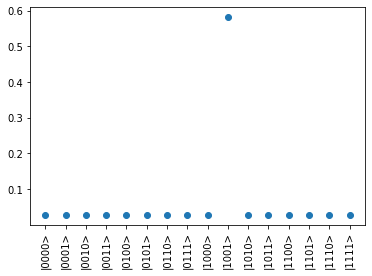

In [103]:
#Pintamos las Probabilidades por estado
plt.scatter(x=range(len(States)), y=Probabilities)
plt.xticks(range(len(States)), States, rotation='vertical')

## 2. Algoritmo Grover Completo

Ya tenemos todos los elementos necesarios para montar un algoritmo de Grover que sea cuasi infalible:

* 1. La combinación de estados equiprobables: $|\Psi\rangle_{n} = \frac{1}{2^{n/2}}\sum_{x}|x\rangle_{n}$
* 2. El oráculo (reflexión en torno a un vector perpendicular al estado ganador): $U_f = I -2|\omega \rangle \langle \omega|$
* 3. El operador difusor: $D_{f0} = H^{\otimes n}U_{f0}H^{\otimes n}= H^{\otimes n}(2|0\rangle \langle 0| -I)H^{\otimes n}$.

El algoritmo de Grover sabemos que lo que hace es:

$$ (D_{f0} U_f )^r |\Psi\rangle_{n} $$

¿Cuántas veces tenemos que aplicar **r**?

Sabemos que:
$$ (D_{f0} U_f )^r |\Psi\rangle_{n} = cos(\frac{2r+1}{2}\theta) |\omega_{T}\rangle + sen(\frac{2r+1}{2}\theta) |\omega\rangle $$

Donde:
* $|\omega\rangle$ es el auto estado ganador
* $|\omega_{T}\rangle$ es un vector perpendicular al estado ganador

En este caso la combinación de estados equiprobables se puede poner como:

$$|\Psi\rangle_{n} = cos(\frac{\theta}{2}) |\omega_{T}\rangle + sen(\frac{\theta}{2}) |\omega\rangle $$

La forma de maximiza la probabilidad de obtener el estado $|\omega\rangle$  es simplemente aplicar el algoritmo de Grover **r** veces:

$$r=\frac{\pi}{2\theta} - \frac{1}{2}$$

donde 

$$sen(\frac{\theta}{2}) = \sqrt{\frac{1}{2^{n}}}$$





N_max: 64
Winner: 49
110001
El ángulo que se rota en cada iteracion del algoritmo de Grover será: 0.2506556623361308
El número de veces que se debe aplicar el algoritmo de Grover (r) para obtener una solución es:5


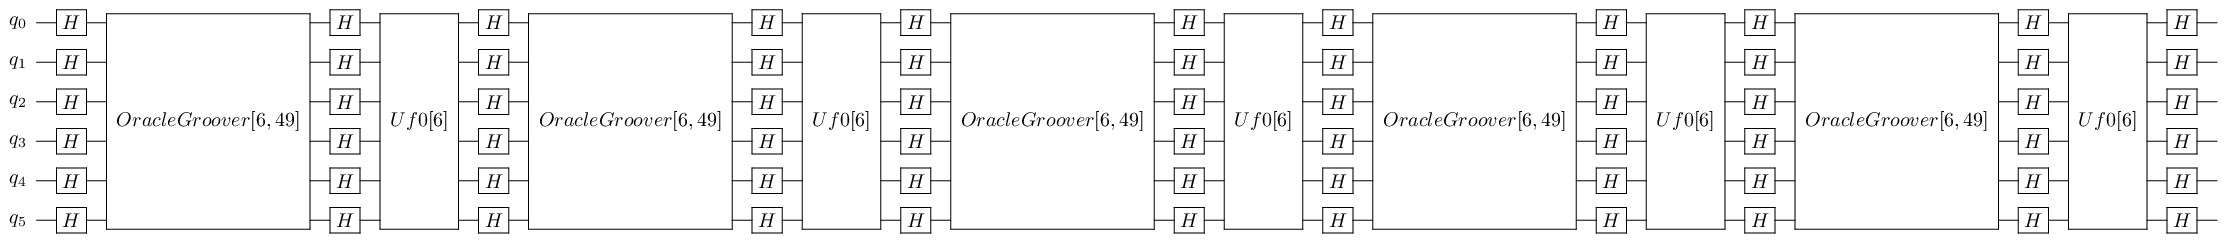

In [112]:

#Inicializamos el program
NumberOfQbits = 6
#Montamos la Loteria
Winner = Loteria(NumberOfQbits)
print(ToBinnary(Winner, NumberOfQbits))
#Aungulo que se rota en cada iteracion de Grover
Theta = 2*np.arcsin(np.sqrt(1/(2**NumberOfQbits)))
print('El ángulo que se rota en cada iteracion del algoritmo de Grover será: {}'.format(Theta))
#Calculamos el numero de veces que tenemos que implementar Grover
r = int(np.pi/(2*Theta)-0.5)
print('El número de veces que se debe aplicar el algoritmo de Grover (r) para obtener una solución es:{}'.format(r))

#Definimos el circuito
Circuit = Program()
#Reservamos los qbits que queremos
qbits = Circuit.qalloc(NumberOfQbits)
#Aplicamos el Operado Hadamard n tensorial
Circuit.apply(TensorialHaddamard(NumberOfQbits),qbits)
#Aplicamos el Algoritmo de Grover r veces
for i in range(r):
    Circuit.apply(Grover(NumberOfQbits, Winner),qbits)
Groover = Circuit.to_circ()
%qatdisplay Groover

In [117]:
from qat.qpus import LinAlg
linalgqpu = LinAlg()
Job4Groover = Groover.to_job()
result = linalgqpu.submit(Job4Groover)
#Me saca Amplitudes Negativas
States = []
Probabilities =[]
#Para ver como funciona calculamos todos los estados posibles
#Y sus probabilidades asociadas

for sample in result:
    States.append(str(sample.state))
    #Probabilidad del estado
    Probabilities.append(np.absolute(sample.amplitude)**2)

#Buscamos el Estado con la mayor probabilidad
idMax = Probabilities.index(max(Probabilities))
Ganador=str(States[idMax]).replace('|','').replace('>', '')
print('Estado con la mayor Probabilidad: {} -> {}. Probabilidad: {}'.format(
    Ganador, int(Ganador,2), Probabilities[idMax]))   

Estado con la mayor Probabilidad: 110001 -> 49. Probabilidad: 0.9635154816192


In [114]:
Probabilities[0]

0.0005791193393775897

In [115]:
Probabilities[idMax]

0.9635154816192